# Generate music with Variational AutoEncoder

## Introduction
In this notebook, we have developed a generative model that could generate music from a variational autoencoder trained with a category of music. We have selected the jazz and classical music categories. The entire model is implemented in TensorFlow and used Librosa for audio processing. The input sampling rate is 3000 for processing the audio file into a readable array.

## What is Variational AutoEncoder?
 VAE is an autoencoder whose encodings distribution is regularised during the training in order to ensure that its latent space has good properties allowing us to generate some new data. A variational autoencoder (VAE) provides a probabilistic manner for describing an observation in latent space.
![VAE](https://miro.medium.com/max/3080/1*82EghOQR2Z5uuwUjFiVV2A.png) 

Source -  [The Intuition Behind Variational Autoencoders](https://medium.com/@realityenginesai/understanding-variational-autoencoders-and-their-applications-81a4f99efc0d), [Variational autoencoders.](https://www.jeremyjordan.me/variational-autoencoders/)

In [1]:
# !/opt/conda/bin/python3.7 -m pip install --upgrade pip
# !pip install tensorflow-addons
# !pip install --upgrade --ignore-installed tensorflow
# !pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
import librosa

import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers 

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [4]:
train_size = 60000
BATCH_SIZE = 10
test_size = 10000
epochs = 20
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 10

BASE_PATH = '../input/gtzan-dataset-music-genre-classification/Data/genres_original'

## Data preprocessing

In [5]:
def DatasetLoader(class_):
    music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
    train_music_1 = list(music_list[[0,52,19,39,71,12,75,85,3,45,24,46,88]]) #99,10,66,76,41
    train_music_2 = list(music_list[[4,43,56,55,45,31,11,13,70,37,21,78]]) #65,32,53,22,19,80,89,
    TrackSet_1 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_1]
    TrackSet_2 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_2]

    return TrackSet_1, TrackSet_2

In [6]:
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30)
    data_ = data_.reshape(1,90001)
    return data_
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

# Generation Music Jazz

In [7]:
TrackSet_1, TrackSet_2 = DatasetLoader('jazz')

## sample original music

In [8]:
sample = TrackSet_1[1]
sample_, sampling_rate = librosa.load(sample,sr=3000, offset=0.0, duration=30)
ipd.Audio(sample_,rate=3000)

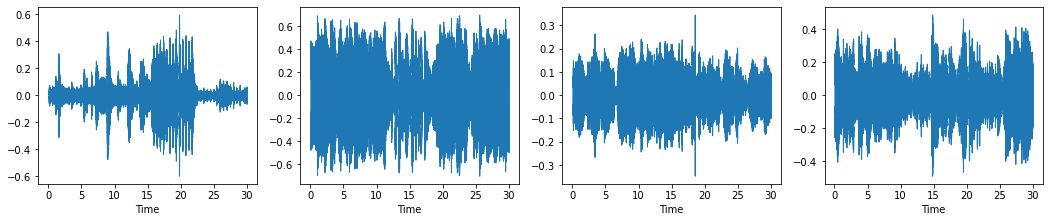

In [9]:
import librosa.display
plt.figure(figsize=(18,15))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    j = load(TrackSet_1[i])
    librosa.display.waveshow(j[0], sr=3000)
    

In [10]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

## Explaining the concept

## Encoder network
This defines the approximate posterior distribution *q(z|x)*, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation *z*. In this example, we simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. We output log-variance instead of the variance directly for numerical stability.
## Decoder network
This defines the conditional distribution of the observation *p(x|z)*, which takes a latent sample *z* as input and outputs the parameters for a conditional distribution of the observation. We model the latent distribution prior *p(z)* as a unit Gaussian.
## Reparameterization
To generate a sample *z* for the decoder during training, we can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation *x*. However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, we use a reparameterization trick. In our example, we approximate *z* using the decoder parameters and another parameter *ϵ* as follows:

z = μ + σ.ϵ

Source: [Tensorflow](https://www.tensorflow.org/tutorials/generative/cvae)

## Network architecture

In [11]:
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters,type='encode'):
        super(Resnet1DBlock, self).__init__(name='')
    
        if type=='encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        if type=='decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)

In [12]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1,90001)),
                layers.Conv1D(64,1,2),
                Resnet1DBlock(64,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(256,1,2),
                Resnet1DBlock(256,1),
                # No activation
                layers.Flatten(),
                layers.Dense(latent_dim+latent_dim)

            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                layers.Reshape(target_shape=(1,latent_dim)),
                Resnet1DBlock(512,1,'decode'),
                layers.Conv1DTranspose(512,1,1),
                Resnet1DBlock(256,1,'decode'),
                layers.Conv1DTranspose(256,1,1),
                Resnet1DBlock(128,1,'decode'),
                layers.Conv1DTranspose(128,1,1),
                Resnet1DBlock(64,1,'decode'),
                layers.Conv1DTranspose(64,1,1),
                # No activation
                layers.Conv1DTranspose(90001,1,1),
            ]
        )
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [13]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

In [14]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

In [15]:
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

## Loss Optimization
Here we have optimized two lossess, the **KL loss** and **reconstruction loss**.<br>

## KL Loss

The KL divergence tells us how well the probability distribution Q approximates the probability distribution P by calculating the cross-entropy minus the entropy. Intuitively, you can think of that as the statistical measure of how one distribution differs from another.
In VAE, let X be the data we want to model, z be latent variable, P(X) be the probability distribution of data, P(z) be the probability distribution of the latent variable and P(X|z) be the distribution of generating data given latent variable.

In the case of variational autoencoders, our objective is to infer P(z)
from P(z|X). P(z|X) is the probability distribution that projects our data into latent space. But since we do not have the distribution P(z|X), we estimate it using its simpler estimation Q.

Now while training our VAE, the encoder should try to learn the simpler distribution Q(z|X)
such that it is as close as possible to the actual distribution P(z|X). This is where we use KL divergence as a measure of a difference between two probability distributions. The VAE objective function thus includes this KL divergence term that needs to be minimized.

*DKL[Q(z|X)||P(z|X)] = E[ logQ(z|X) − logP(z|X) ]*

The loss function we need to estimate is

\begin{equation}
-\mathrm{ELBO} = \mathrm{KL}[ \ q(z|x) \ || \ p(z) \ ] - \mathrm{E}_{Z \sim q(z|x)}[\log p(x|Z)]\\
\end{equation}

where $x = (x_1, x_2, \ldots, x_n)$ refers to all observations, $z = (z_1, z_2, \ldots, z_n)$ refers to corresponding latent variables.

## Reconstruction loss
As the name suggest, it measures the reconstruction of original input x. This network can be trained by minimizing the reconstruction error, which measures the differences between our original input and the consequent reconstruction.

In [16]:
@tf.function

def train_step(model, x, optimizer):
    
    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss + loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [17]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [18]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

## Training the model

In [19]:

def train(train_dataset, test_dataset, model, save):
    ElboScores = []
    train_losses = []
    test_losses = []
    KL_Loss = []
    RC_Loss = []
    Total_Loss = []

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        train_loss = tf.keras.metrics.Mean()
        
        loss_KL = 0
        reconstruction_loss = 0
        total_loss = 0
        TrainLoss = 0
        
        for train_x in train_dataset:
            train_x = np.asarray(train_x)[0]
            
            mean, logvar = model.encode(train_x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=train_x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(train_x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
            
            
            train_loss(compute_loss(model, train_x))
            TrainLoss = train_loss.result()
            train_step(model, train_x, optimizer)
        
        train_losses.append(TrainLoss)
        KL_Loss.append(loss_KL)
        RC_Loss.append(reconstruction_loss)
        Total_Loss.append(total_loss)
        
        end_time = time.time()

        test_loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            test_x = np.asarray(test_x)[0]
            test_loss(compute_loss(model, test_x))
        
        elbo = -test_loss.result()
        test_losses.append(test_loss.result())
        ElboScores.append(float(elbo))
        
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {} \n'.format(epoch, 
                                                                                       elbo, 
                                                                                       end_time - start_time
                                                                                      ))
    return ElboScores, KL_Loss, RC_Loss, Total_Loss, train_losses, test_losses


ElboScores, KL_Loss, RC_Loss, Total_Loss, train_losses, test_losses = train(train_dataset, test_dataset, model, 'jazz')

Epoch: 1, Test set ELBO: -62306.99609375, time elapse for current epoch: 26.872152090072632 

Epoch: 2, Test set ELBO: -62265.6953125, time elapse for current epoch: 8.784003496170044 

Epoch: 3, Test set ELBO: -62081.18359375, time elapse for current epoch: 8.872913122177124 

Epoch: 4, Test set ELBO: -62014.1796875, time elapse for current epoch: 9.004944086074829 

Epoch: 5, Test set ELBO: -61477.6875, time elapse for current epoch: 8.612162113189697 

Epoch: 6, Test set ELBO: -61202.4296875, time elapse for current epoch: 9.234304666519165 

Epoch: 7, Test set ELBO: -60597.09375, time elapse for current epoch: 8.974231243133545 

Epoch: 8, Test set ELBO: -58702.96484375, time elapse for current epoch: 8.981194496154785 

Epoch: 9, Test set ELBO: -58109.73828125, time elapse for current epoch: 8.786251544952393 

Epoch: 10, Test set ELBO: -56692.265625, time elapse for current epoch: 8.88075876235962 

Epoch: 11, Test set ELBO: -54036.48046875, time elapse for current epoch: 8.86918

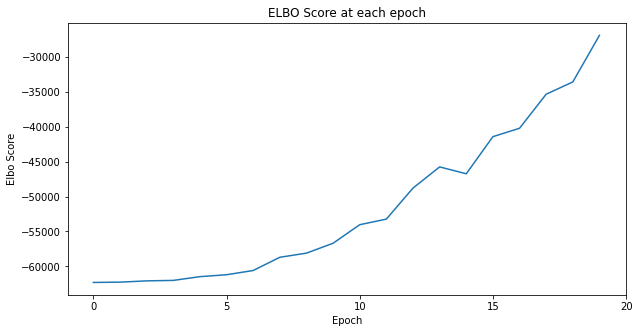

In [20]:
plt.figure(figsize=(10,5))
plt.plot(ElboScores)
plt.title('ELBO Score at each epoch')
plt.xticks(np.arange(0,epochs+1, 5))
plt.xlabel('Epoch')
plt.ylabel('Elbo Score')
plt.show()

## Reconstruction Loss - Jazz

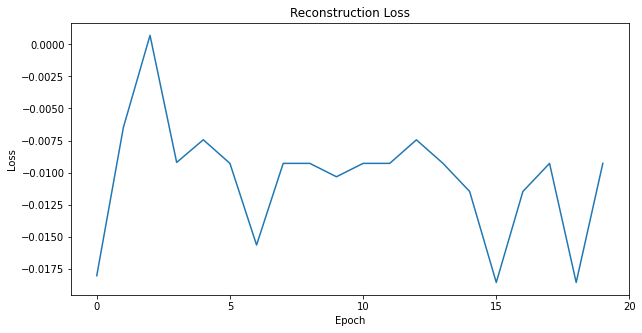

In [21]:
plt.figure(figsize=(10,5))
plt.plot(RC_Loss)
plt.title('Reconstruction Loss')
plt.xticks(np.arange(0,epochs+1, 5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## KL Divergence Loss - Jazz

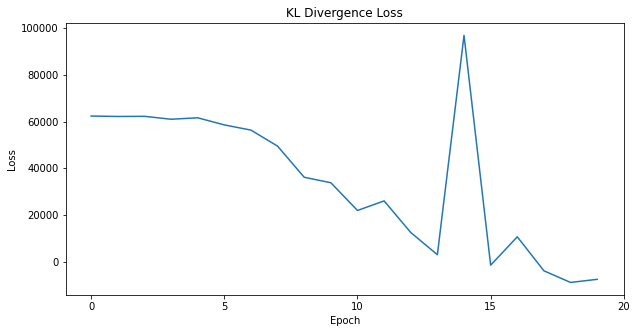

In [22]:
plt.figure(figsize=(10,5))
plt.plot(KL_Loss)
plt.title('KL Divergence Loss')
plt.xticks(np.arange(0,epochs+1, 5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Total Loss - Jazz

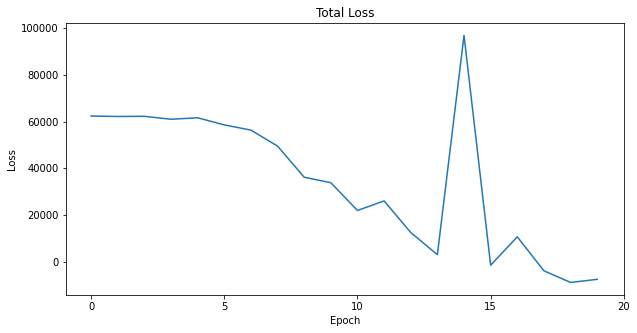

In [23]:
plt.figure(figsize=(10,5))
plt.plot(Total_Loss)
plt.title('Total Loss')
plt.xticks(np.arange(0,epochs+1, 5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('total_loss.png')
plt.show()

## Generated Music - Jazz
Let us listen to the music generated by our model, trained only with classical music.

In [24]:
def inference(test_dataset, model):  
    save_music = []
    for test in test_dataset:
        mean, logvar = model.encode(test)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        for pred in predictions:
            wave = np.asarray(pred)
            save_music.append(wave)
    return save_music

saved_musics = inference(test_dataset, model)

In [25]:
music1=saved_musics[0][0]
ipd.Audio(music1,rate=3000)

In [26]:
music2=saved_musics[9][0]
ipd.Audio(music2,rate=3000)

In [27]:
music3=saved_musics[5][0]
ipd.Audio(music3,rate=3000)

In [28]:
music4=saved_musics[10][0]
ipd.Audio(music4,rate=3000)

In [29]:
music5=saved_musics[8][0]
ipd.Audio(music5,rate=3000)

In [30]:
music6=saved_musics[7][0]
ipd.Audio(music6,rate=3000)

# Generate Classical Music
Let's try out another example with classical music. The code shown below is the same as above, its just the same experiment over a different music category.

In [31]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [32]:
TrackSet_3, TrackSet_4 = DatasetLoader('classical')

In [33]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_3))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_4))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

In [34]:
model = CVAE(latent_dim)

In [35]:
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

In [36]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    
    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [37]:
ElboScores, KL_Loss, RC_Loss, Total_Loss, train_losses, test_losses = train(train_dataset, test_dataset, model, 'classical')

Epoch: 1, Test set ELBO: -62322.6953125, time elapse for current epoch: 17.50755286216736 

Epoch: 2, Test set ELBO: -62278.66015625, time elapse for current epoch: 8.755347728729248 

Epoch: 3, Test set ELBO: -62043.05078125, time elapse for current epoch: 8.9855477809906 

Epoch: 4, Test set ELBO: -61961.640625, time elapse for current epoch: 8.941858530044556 

Epoch: 5, Test set ELBO: -60391.9609375, time elapse for current epoch: 8.877923250198364 

Epoch: 6, Test set ELBO: -60133.3203125, time elapse for current epoch: 8.949115514755249 

Epoch: 7, Test set ELBO: -58649.890625, time elapse for current epoch: 8.798287630081177 

Epoch: 8, Test set ELBO: -49701.1953125, time elapse for current epoch: 8.942664623260498 

Epoch: 9, Test set ELBO: -52457.7578125, time elapse for current epoch: 8.962613344192505 

Epoch: 10, Test set ELBO: -49997.84765625, time elapse for current epoch: 8.6995210647583 

Epoch: 11, Test set ELBO: -44202.8046875, time elapse for current epoch: 8.8491134

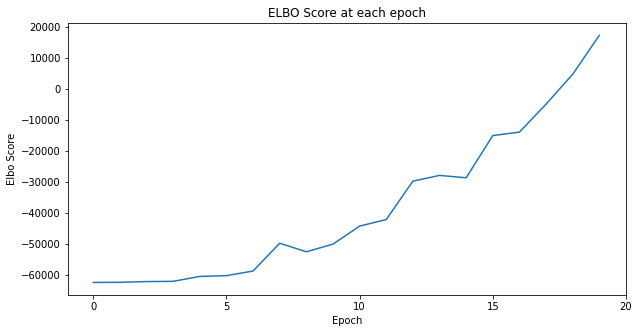

In [38]:
plt.figure(figsize=(10,5))
plt.plot(ElboScores)
plt.title('ELBO Score at each epoch')
plt.xticks(np.arange(0,epochs+1, 5))
plt.xlabel('Epoch')
plt.ylabel('Elbo Score')
plt.show()

## Reconstruction Loss - Classical

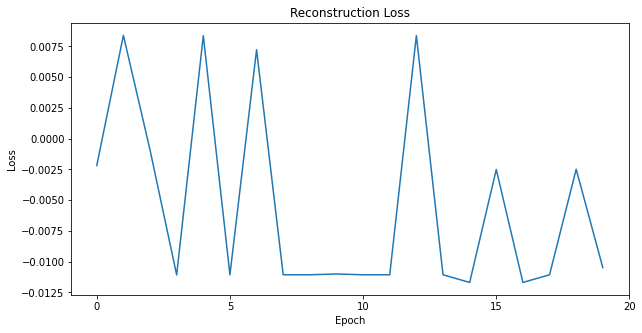

In [39]:
plt.figure(figsize=(10,5))
plt.plot(RC_Loss)
plt.title('Reconstruction Loss')
plt.xticks(np.arange(0,epochs+1, 5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## KL Divergence Loss - Classical

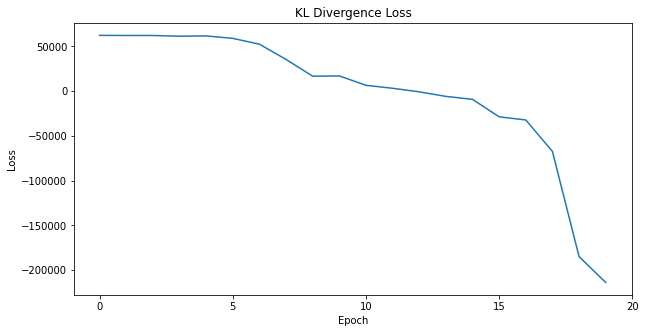

In [40]:
plt.figure(figsize=(10,5))
plt.plot(KL_Loss)
plt.title('KL Divergence Loss')
plt.xticks(np.arange(0,epochs+1, 5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Total Loss - Classical

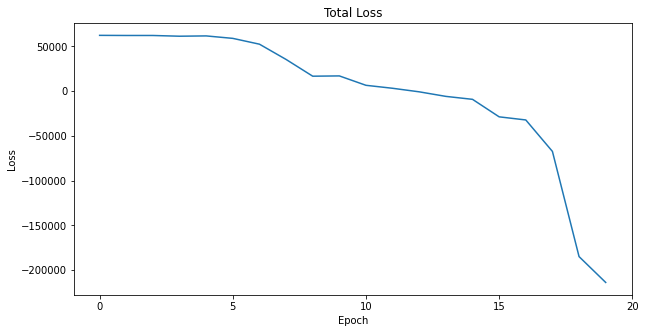

In [41]:
plt.figure(figsize=(10,5))
plt.plot(Total_Loss)
plt.title('Total Loss')
plt.xticks(np.arange(0,epochs+1, 5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('total_loss.png')
plt.show()

## Generation music - Classical

In [42]:
save_music_classic = inference(test_dataset, model)

In [43]:
music1=save_music_classic[1][0]
ipd.Audio(music1,rate=3000)

In [44]:
music2=save_music_classic[9][0]
ipd.Audio(music2,rate=3000)

In [45]:
music3=save_music_classic[4][0]
ipd.Audio(music3,rate=3000)

In [46]:
music4=save_music_classic[5][0]
ipd.Audio(music4,rate=3000)

In [47]:
music5=save_music_classic[8][0]
ipd.Audio(music5,rate=3000)

In [48]:
music6=save_music_classic[7][0]
ipd.Audio(music6,rate=3000)

## Conclusion
**WoW! the generated music sounds really good....**
<br>
First of all, We got to learn a lot while working on this project. We have implemented the model which works only for music generation, for generating a lyrical song this model won't generate a promising result. For generating lyrical songs birectional lstm, transformer networks and attention layers would be a better choice according to me for contructing the network architecture. Also, we have trained my model against a particular category of music, this solution could also be made more interesting by training the model against two or more categories of music.